# DCN Goodreads Recommendation System

---
## Prepare the Data

Setup

In [1]:
import json
import os
import numpy as np
import pandas as pd
from IPython.display import display
import pprint
import tensorflow as tf
import math
from tensorflow import keras
from tensorflow.keras import layers
import datetime

Dataset Directory

In [2]:
DIR = './data/cleaned/'
fn_books = 'goodreads_books_mystery_thriller_crime.pkl'
fn_reviews = 'goodreads_reviews_mystery_thriller_crime.pkl'
fn_genres = 'goodreads_book_genres_initial.pkl'

In [3]:
df_reviews = pd.read_pickle(os.path.join(DIR, fn_reviews))
df_books = pd.read_pickle(os.path.join(DIR, fn_books))
df_genres = pd.read_pickle(os.path.join(DIR, fn_genres))

In [4]:
df_genres.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 250000 entries, 5333265 to 2356633
Data columns (total 10 columns):
 #   Column                                  Non-Null Count   Dtype
---  ------                                  --------------   -----
 0   history, historical fiction, biography  250000 non-null  int32
 1   fiction                                 250000 non-null  int32
 2   fantasy, paranormal                     250000 non-null  int32
 3   mystery, thriller, crime                250000 non-null  int32
 4   poetry                                  250000 non-null  int32
 5   romance                                 250000 non-null  int32
 6   non-fiction                             250000 non-null  int32
 7   children                                250000 non-null  int32
 8   young-adult                             250000 non-null  int32
 9   comics, graphic                         250000 non-null  int32
dtypes: int32(10)
memory usage: 11.4 MB


In [5]:
df_join = pd.merge(df_reviews, df_books, left_on="book_id", right_index=True)
df_join.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,popular_shelves,average_rating,description,author_id,author_name
review_id,,,,,,,,,,,
0e317947e1fd341f573192111bb2921d,8842281e1d1347389f2ab93d60773d4d,8694005,3,The Name of the Rose is a thrilling Dan Brown-...,b'The Name of the Rose',99,"[{'count': '8209', 'name': 'to-read'}, {'count...",4.11,The year is 1327. Franciscans in a wealthy Ita...,1730,Umberto Eco
4276918357312212384ac6415ceb9159,8842281e1d1347389f2ab93d60773d4d,6652906,3,** spoiler alert ** Hooked me equally as wel...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson
9ee704921386f88893900829c037abd0,4fdf8e419e36ae2e82bc44376768e280,6652906,4,Don't start these books unless you're ready to...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson
26e59823f1936fe9030d85262f1477e1,446728d221c1343b92e1e4ff5545a843,6652906,5,Loved it! Not as much as the first but it this...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson
83370bd38023a2fd928b2b6114c2b210,fe0ad83a30bcd7fbe65ac1670b2b01e1,6652906,5,Once again Larsson does not disappoint. Althou...,"b'The Girl Who Played with Fire (Millennium, #2)'",772,"[{'count': '6613', 'name': 'fiction'}, {'count...",4.22,"Part blistering espionage thriller, part rivet...",706255,Stieg Larsson


In [6]:
df_join = pd.merge(df_join, df_genres, left_on="book_id", right_index=True)
df_join.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,popular_shelves,average_rating,description,author_id,...,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,,,,,,,,,,,,
d44b6d28f456dbcc5b1537b4c5572400,8842281e1d1347389f2ab93d60773d4d,6411961,3,"** spoiler alert ** Critics aside, Dan Brown...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
41e98a56ec0abd77d9191b4f1e2cd806,40b795551cd5b1dae85ff2f7b8ddee27,6411961,2,"While the book is a page-turner, I found the p...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
9ccb9f3b2719283bd8a6d24c297cd738,2193b39163317f53641d1f8539a4586c,6411961,3,As always well written and you have to keep re...,"b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
a4f43a0a2703c9c46a18ba1b8a7a2b90,21e67f8f9a1679070e93ff8a152efde6,6411961,3,"I am sorry to say this, but i found the plot o...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0
0b8368d5286c6ebf3a22a7ed3572b513,1939a0e8cacc2101a1f6d5446d91de78,6411961,4,"Book two - loved it, couldn't put down until I...","b'The Lost Symbol (Robert Langdon, #3)'",21569,"[{'count': '9279', 'name': 'currently-reading'...",3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,...,861,6059,115,8244,0,0,0,0,0,0


In [7]:
df_join.describe()

,book_id,rating,text_reviews_count,average_rating,author_id,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
count,1.089900e+04,10899.000000,10899.000000,10899.000000,1.089900e+04,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000,10899.000000
mean,1.271280e+07,3.718873,1922.866869,3.863832,2.223974e+06,38.609964,602.765850,28.801633,1117.014038,0.022846,19.107533,5.644830,2.619782,30.007524,0.068171
std,1.057604e+07,1.164748,4954.590599,0.287245,3.700216e+06,161.711543,1639.162593,121.687751,2647.616474,0.826881,79.539608,158.885851,46.250787,204.250718,1.743413
min,2.300000e+02,0.000000,1.000000,2.190000,1.310000e+02,-1.000000,-1.000000,-4.000000,2.000000,0.000000,-3.000000,-1.000000,0.000000,-1.000000,-2.000000
25%,1.244206e+06,3.000000,34.000000,3.700000,1.706250e+04,0.000000,13.000000,0.000000,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.277838e+07,4.000000,187.000000,3.890000,1.565230e+05,0.000000,68.000000,0.000000,210.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.129745e+07,5.000000,1043.000000,4.060000,3.317636e+06,0.000000,318.000000,0.000000,836.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
max,3.640284e+07,5.000000,24868.000000,4.890000,1.732060e+07,2410.000000,17771.000000,1555.000000,22104.000000,48.000000,1683.000000,8049.000000,1992.000000,2305.000000,92.000000


In [8]:
df_join.dtypes

user_id                                    object
book_id                                    uint32
rating                                      uint8
review_text                                object
title                                      object
text_reviews_count                         uint32
popular_shelves                            object
average_rating                            float64
description                                object
author_id                                   int64
author_name                                object
history, historical fiction, biography      int32
fiction                                     int32
fantasy, paranormal                         int32
mystery, thriller, crime                    int32
poetry                                      int32
romance                                     int32
non-fiction                                 int32
children                                    int32
young-adult                                 int32


In [9]:
data = df_join.drop("popular_shelves",axis='columns')

In [10]:
data.head()

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id,author_name,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,,,,,,,,,,,
d44b6d28f456dbcc5b1537b4c5572400,8842281e1d1347389f2ab93d60773d4d,6411961,3,"** spoiler alert ** Critics aside, Dan Brown...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
41e98a56ec0abd77d9191b4f1e2cd806,40b795551cd5b1dae85ff2f7b8ddee27,6411961,2,"While the book is a page-turner, I found the p...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
9ccb9f3b2719283bd8a6d24c297cd738,2193b39163317f53641d1f8539a4586c,6411961,3,As always well written and you have to keep re...,"b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
a4f43a0a2703c9c46a18ba1b8a7a2b90,21e67f8f9a1679070e93ff8a152efde6,6411961,3,"I am sorry to say this, but i found the plot o...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0
0b8368d5286c6ebf3a22a7ed3572b513,1939a0e8cacc2101a1f6d5446d91de78,6411961,4,"Book two - loved it, couldn't put down until I...","b'The Lost Symbol (Robert Langdon, #3)'",21569,3.66,WHAT IS LOST... WILL BE FOUND In this stunning...,630,Dan Brown,861,6059,115,8244,0,0,0,0,0,0


In [11]:
data.sample(5)

,user_id,book_id,rating,review_text,title,text_reviews_count,average_rating,description,author_id,author_name,"history, historical fiction, biography",fiction,"fantasy, paranormal","mystery, thriller, crime",poetry,romance,non-fiction,children,young-adult,"comics, graphic"
review_id,,,,,,,,,,,,,,,,,,,,
57e4b2b9b581229d6218c9716a39fefa,3a05839232db02692ef070ebc0fe6469,23395340,3,Pretty good but not great.,b'No Such Person',121,3.27,From the author of the multimillion-copy bests...,9059,Caroline B. Cooney,0,29,0,94,0,2,0,1,53,0
fbcbbaa340f1742540947aa663245af7,b06bd9929b82d50b0173373e8ae8917b,18693918,4,Ms. Hoag obviously did her homework before wri...,b'Cold Cold Heart',874,3.85,#1 New York Timesbestselling author Tami Hoag ...,9890,Tami Hoag,0,84,0,267,0,0,0,0,0,0
e493c03dc720b90da918589509a54c08,0709eeea1c65a58c65ea15fe803d07d8,11148249,2,"Enjoyed the characters, especially Rain, but I...",b'The Girl in the Park',292,3.57,When Wendy Geller's body is found in Central P...,259431,Mariah Fredericks,0,44,0,152,0,2,0,0,97,0
6d3e24785d9f951241243180d3b97065,db5df89abe59f5e11d560aa50a7973eb,1263409,4,A beautifully written novel about love & guilt...,b'Diablerie',122,3.29,An icy noir from a master of American fiction ...,20850,Walter Mosley,0,33,0,29,0,0,0,0,0,0
5b9ec3d7e6a6db7043a05137788553bb,3d9e0ae494ee343409fd33d9d54bab8e,22259002,4,Good short story about a boy and his sister wh...,b'The Neighbor',341,3.86,a prequel to The City The year is 1967. Malcol...,9355,Dean Koontz,0,27,16,49,0,0,0,0,0,0


fix datatypes

In [12]:
data['review_text'] = data['review_text'].astype('string')
data['description'] = data['description'].astype('string')
data['title']= data['title'].astype('string')
data['author_name']= data['author_name'].astype('string')

In [13]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10899 entries, d44b6d28f456dbcc5b1537b4c5572400 to 40e135e86dcc1e5920284a4c674cc8cb
Data columns (total 20 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   user_id                                 10899 non-null  object 
 1   book_id                                 10899 non-null  uint32 
 2   rating                                  10899 non-null  uint8  
 3   review_text                             10899 non-null  string 
 4   title                                   10899 non-null  string 
 5   text_reviews_count                      10899 non-null  uint32 
 6   average_rating                          10899 non-null  float64
 7   description                             10899 non-null  string 
 8   author_id                               10899 non-null  int64  
 9   author_name                             10899 non-null  string 
 10  histo

rename genre columns

In [14]:
data.rename(columns={"comics, graphic": "comics_graphic", 
                     "history, historical fiction, biography": "history_historical_fiction_biography", 
                     "fantasy, paranormal": "fantasy_paranormal", 
                     "mystery, thriller, crime": "mystery_thriller_crime"},
            inplace=True)

In [15]:
data.dropna(inplace=True)

Let's split the data into training (80%) and test (20%) sets.

In [17]:
TARGET_FEATURE_NAME = "rating"  # individual rating
split = 0.8

In [18]:
train_splits = []
test_splits = []

for _, group_data in data.groupby(TARGET_FEATURE_NAME):
    random_selection = np.random.rand(len(group_data.index)) <= split
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train split size: {len(train_data.index)}")
print(f"Test split size: {len(test_data.index)}")


Train split size: 8682
Test split size: 2217


Durch den Merge wurden aus (50k Büchern ∩ 100k Reviews ∩ 250k Genres) ≅ 10k kombinierte Datenpunkte!

In [19]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(os.path.join(DIR, train_data_file), index=False)
test_data.to_csv(os.path.join(DIR, test_data_file), index=False)

In [20]:
CSV_HEADER = list(train_data.columns)

---
## Define dataset metadata
Here, we define the metadata of the dataset that will be useful for reading and parsing the data into input features, and encoding the input features with respect to their types.



In [42]:
TARGET_FEATURE_LABELS = [i for i in range(6)]
# normalization
NUMERIC_FEATURE_NAMES = [
    "text_reviews_count",   # popularity
    "average_rating"
]
# text vectorization + embedding
TEXT_FEATURE_NAMES = [
    "review_text",
    "title",
    "description",
    "author_name"
]
# integer lookup
CATEGORICAL_INT_FEATURE_NAMES = [
    "book_id",
    "author_id",
]
# string lookup
CATEGORICAL_STR_FEATURE_NAMES = [
    "user_id",
]
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "user_id": list(data["user_id"].unique()),
    "author_id": list(data["author_id"].unique()),
    "book_id": list(data["book_id"].unique()),
}


# integer lookup
CATEGORICAL_MULTI_HOT_FEATURE_NAMES = [
    "history_historical_fiction_biography",
    "fiction",
    "fantasy_paranormal",
    "mystery_thriller_crime",
    "poetry",
    "romance",
    "non-fiction",
    "children",
    "young-adult",
    "comics_graphic"
]
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + \
                TEXT_FEATURE_NAMES + \
                CATEGORICAL_INT_FEATURE_NAMES + \
                CATEGORICAL_STR_FEATURE_NAMES + \
                CATEGORICAL_MULTI_HOT_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in CSV_HEADER
]


NUM_CLASSES = len(TARGET_FEATURE_LABELS)

---
## Experiment setup
Next, let's define an input function that reads and parses the file, then converts features and labels into a `tf.data.Dataset` for training or evaluation.



In [43]:
def get_dataset_from_pandas(dataframe, label_name, batch_size, shuffle=False):
    df = dataframe.copy()
    labels = df.pop(label_name)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.cache()
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [44]:
from email_callback import EmailCallback
dropout_rate = 0.1

hidden_units = [32, 32]


def run_experiment(model, loss=None, metrics=None, learning_rate=0.001, batch_size=128, num_epochs=50):
    import datetime
    _loss = loss if loss is not None else [keras.losses.SparseCategoricalCrossentropy()]
    _metrics = metrics if metrics is not None else [keras.metrics.SparseCategoricalAccuracy(), keras.metrics.SparseCategoricalCrossentropy()]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss=_loss,
        metrics=_metrics,
    )

    train_dataset = get_dataset_from_pandas(train_data, TARGET_FEATURE_NAME, batch_size, shuffle=True)

    test_dataset = get_dataset_from_pandas(test_data, TARGET_FEATURE_NAME, batch_size)

    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    email = EmailCallback(train_size=len(train_data), test_size=len(test_data))
    callbacks = [
        tf.keras.callbacks.TensorBoard(log_dir=log_dir),
        tf.keras.callbacks.EarlyStopping(monitor="loss",patience=5),
        email
    ]

    print("Start training the model...")
    history = model.fit(train_dataset, epochs=num_epochs, callbacks=callbacks)
    print("Model training finished")

    metrics = model.evaluate(test_dataset, verbose=0, callbacks=[email])

    print(metrics)


In [45]:
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=CSV_HEADER,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()


---
## Create model inputs
Now, define the inputs for the models as a dictionary, where the key is the feature name, and the value is a `keras.layers.Input` tensor with the corresponding feature shape and data type.



In [46]:
from tensorflow.keras.layers import IntegerLookup
from tensorflow.keras.layers import Normalization
from tensorflow.keras.layers import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_categorical_feature(feature, name, dataset, is_string, output_mode="multi_hot"):
    lookup_class = StringLookup if is_string else IntegerLookup
    # Create a lookup layer which will turn strings into integer indices
    lookup = lookup_class(output_mode=output_mode)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    lookup.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = lookup(feature)
    return encoded_feature

In [47]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in [*TEXT_FEATURE_NAMES, *CATEGORICAL_STR_FEATURE_NAMES]:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
    return inputs

---
## Encode features

We create two representations of our input features: sparse and dense: 1. In the *sparse* representation, the categorical features are encoded with one-hot encoding using the `CategoryEncoding` layer. This representation can be useful for the model to memorize particular feature values to make certain predictions. 2. In the *dense* representation, the categorical features are encoded with low-dimensional embeddings using the ``Embedding`` layer. This representation helps the model to generalize well to unseen feature combinations.



In [48]:
# Model constants.
max_features = 20000
embedding_dim = 128
sequence_length = 500

In [49]:
CATEGORICAL_STR_FEATURE_NAMES

['user_id']

In [50]:
from tensorflow.keras.layers import StringLookup

call = 1
def encode_inputs(inputs, use_embedding=False):
    global call
    call += 1
    encoded_features = []
    for feature_name in inputs:
        if feature_name in [*CATEGORICAL_STR_FEATURE_NAMES, *CATEGORICAL_INT_FEATURE_NAMES]:
            is_string = (feature_name in CATEGORICAL_STR_FEATURE_NAMES)
            lookup_class = StringLookup if is_string else IntegerLookup
            lookup_name = "string_lookup" if is_string else "integer_lookup"
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]
            lookup = lookup_class(
                vocabulary=vocabulary,
                output_mode="int" if use_embedding else "multi_hot",
                name=f"{lookup_name}_{feature_name}_{call}",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary)+1, output_dim=embedding_dims,
                    name=f"{lookup_name}_embedding_{feature_name}_{call}",
                )
                
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        elif feature_name in TEXT_FEATURE_NAMES:
            vectorize_layer = tf.keras.layers.TextVectorization(max_tokens=max_features, 
            output_sequence_length=sequence_length if use_embedding else None, output_mode="int" if use_embedding else "multi_hot",
            name=f"textvectorization_{feature_name}_{call}",
            )
            vectorize_layer.adapt(data[feature_name])
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = vectorize_layer(inputs[feature_name])
                embedding_dims = 32 #int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=vectorize_layer.vocabulary_size()+1, output_dim=embedding_dims,
                    name=f"tv_embedding_{feature_name}_{call}",
                )
                # average the embedding from sequence_length x batch to 1x32
                averaging = tf.keras.layers.GlobalAveragePooling1D();

                # Convert the index values to embedding representations.
                encoded_feature = averaging(embedding(encoded_feature))
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = vectorize_layer(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)
        
    all_features = layers.concatenate(encoded_features)
    return all_features


---
## Experiment 1: a baseline model
In the first experiment, let's create a multi-layer feed-forward network, where the categorical features are one-hot encoded.


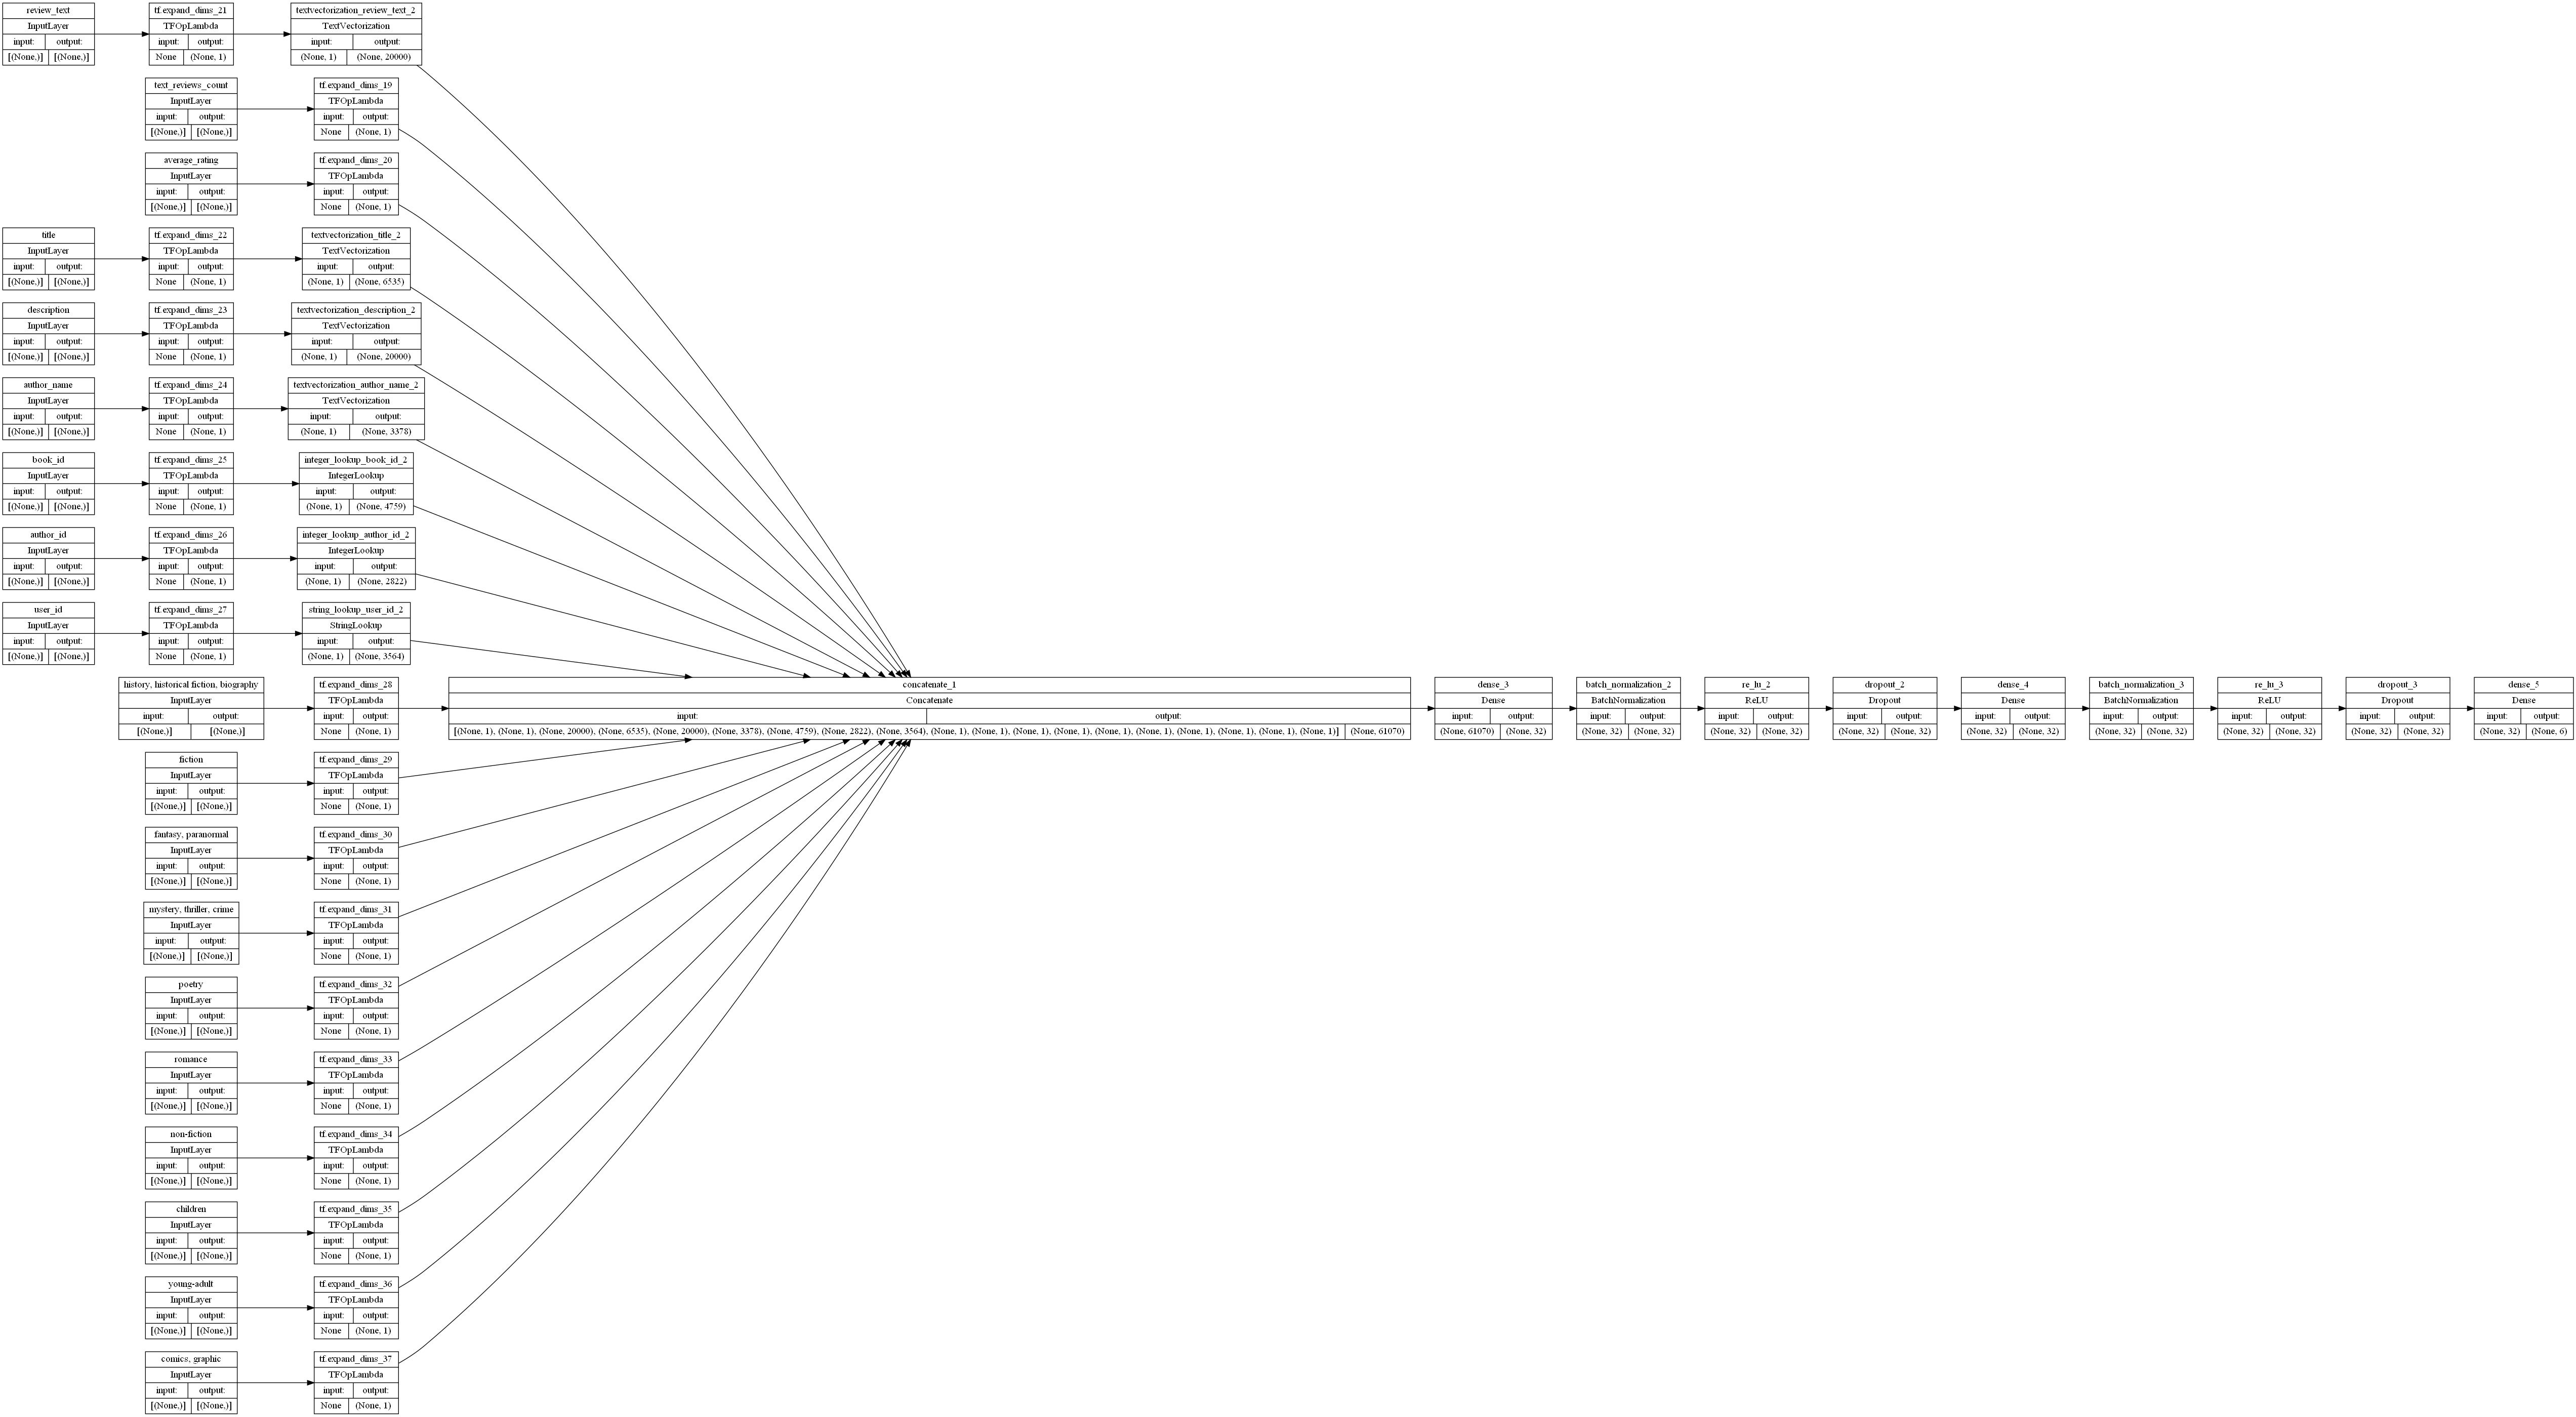

In [51]:
def create_baseline_model():
    inputs = create_model_inputs()
    features = encode_inputs(inputs)

    for units in hidden_units:
        features = layers.Dense(units)(features)
        features = layers.BatchNormalization()(features)
        features = layers.ReLU()(features)
        features = layers.Dropout(dropout_rate)(features)

    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


baseline_model = create_baseline_model()
plot_fn = os.path.join("./logs/model_plots/", "baseline_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")
keras.utils.plot_model(baseline_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [52]:
run_experiment(baseline_model)

setting up yagmail...
Start training the model...
Start Training with Model: 
Model: "model_1"__________________________________________________________________________________________________ Layer (type)                   Output Shape         Param #     Connected to                     ================================================================================================== review_text (InputLayer)       [(None,)]            0           []                                                                                                                                  title (InputLayer)             [(None,)]            0           []                                                                                                                                  description (InputLayer)       [(None,)]            0           []                                                                                                                                  author_name (InputLayer

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\simon\\AppData\\Local\\Temp\\tmpzuj7ct25.png'


Epoch 50/50
33/33 [==============================] - 3s 96ms/step - loss: 13.9775 - sparse_categorical_accuracy: 0.1705 - sparse_categorical_crossentropy: 1.7928

---

mit MAE funktionierts *überhaupt nicht*:

33/33 [==============================] - 6s 173ms/step - loss: 3.5591 - sparse_categorical_accuracy: 0.2904 - sparse_categorical_crossentropy: 1.8936

Model training finished

Test accuracy: 356.12. Test CategoricalCrossEntropy: 0.23%
(vermutlich werte umgekehrt)

Epoch 6/50
33/33 [==============================] - 15s 440ms/step - loss: 3.5591 - sparse_categorical_accuracy: 0.3038 - sparse_categorical_crossentropy: 1.8952

Model training finished
[3.561164140701294, 0.3306415379047394, 1.8279825448989868]

Epoch 43/50
33/33 [==============================] - 5s 143ms/step - loss: 0.4164 - sparse_categorical_accuracy: 0.8359
Model training finished
Test accuracy: 43.11%

Results w/ 8670 pieces of train data and baseline_model @ 15 epochs:
- loss: 0.7961 
- sparse_categorical_accuracy: 0.7035
- Test accuracy: 38.67 %

TODO: Datensatz fetching fixen, er hört sonst nach 16 epochs schon auf :o 8670/265er batches müsste für 32 reichen

## TODO andere Metrics, output ist ja nicht kategorisch, darf gern Regression sein, oder?

Learnings:
- eigentlich Klassifiziere ich gerade folgendes:
  - Gegeben Review mit Title, Beschreibung, Text, UserID, Author, etc. --> prädiziere die Bewertung von 0-5
  - (eigentlich recht easy)

- was ich für eine Recommendation bräuchte (-> Ranking)
- wäre eine prädizierte Bewertung **auf Basis der UserID** und Anhand der Buchfeatures Beschreibung, Titel, Author, etc.
- Dann "einfach" für alle Bücher prädizieren und top K Ergebnisse liefern --> MAP@k, Precision@k
  

wie im TF Tutorial beschrieben:
1. Candidate Model: --> Bücher --> Features
2. Query Model: --> Suchanfrage --> UserModel --> UserID
   - nicht ganz klar, wo die user-bewertungen jetzt konkret rein sollten..

RS-Tasks:
- *item rating prediction (regression)* [42]
- click-through rate prediction (binary classification) [11, 16]
- user behavior prediction (multi-class classification) [59], and
- *item retrieval (clustering)* [10].

In [ ]:
%tensorboard --logdir log_dir

UsageError: Line magic function `%tensorboard` not found.


---
## Experiment 2: Wide & Deep model
In the second experiment, we create a Wide & Deep model. The wide part of the model a linear model, while the deep part of the model is a multi-layer feed-forward network.

Use the sparse representation of the input features in the wide part of the model and the dense representation of the input features for the deep part of the model.

Note that every input features contributes to both parts of the model with different representations.



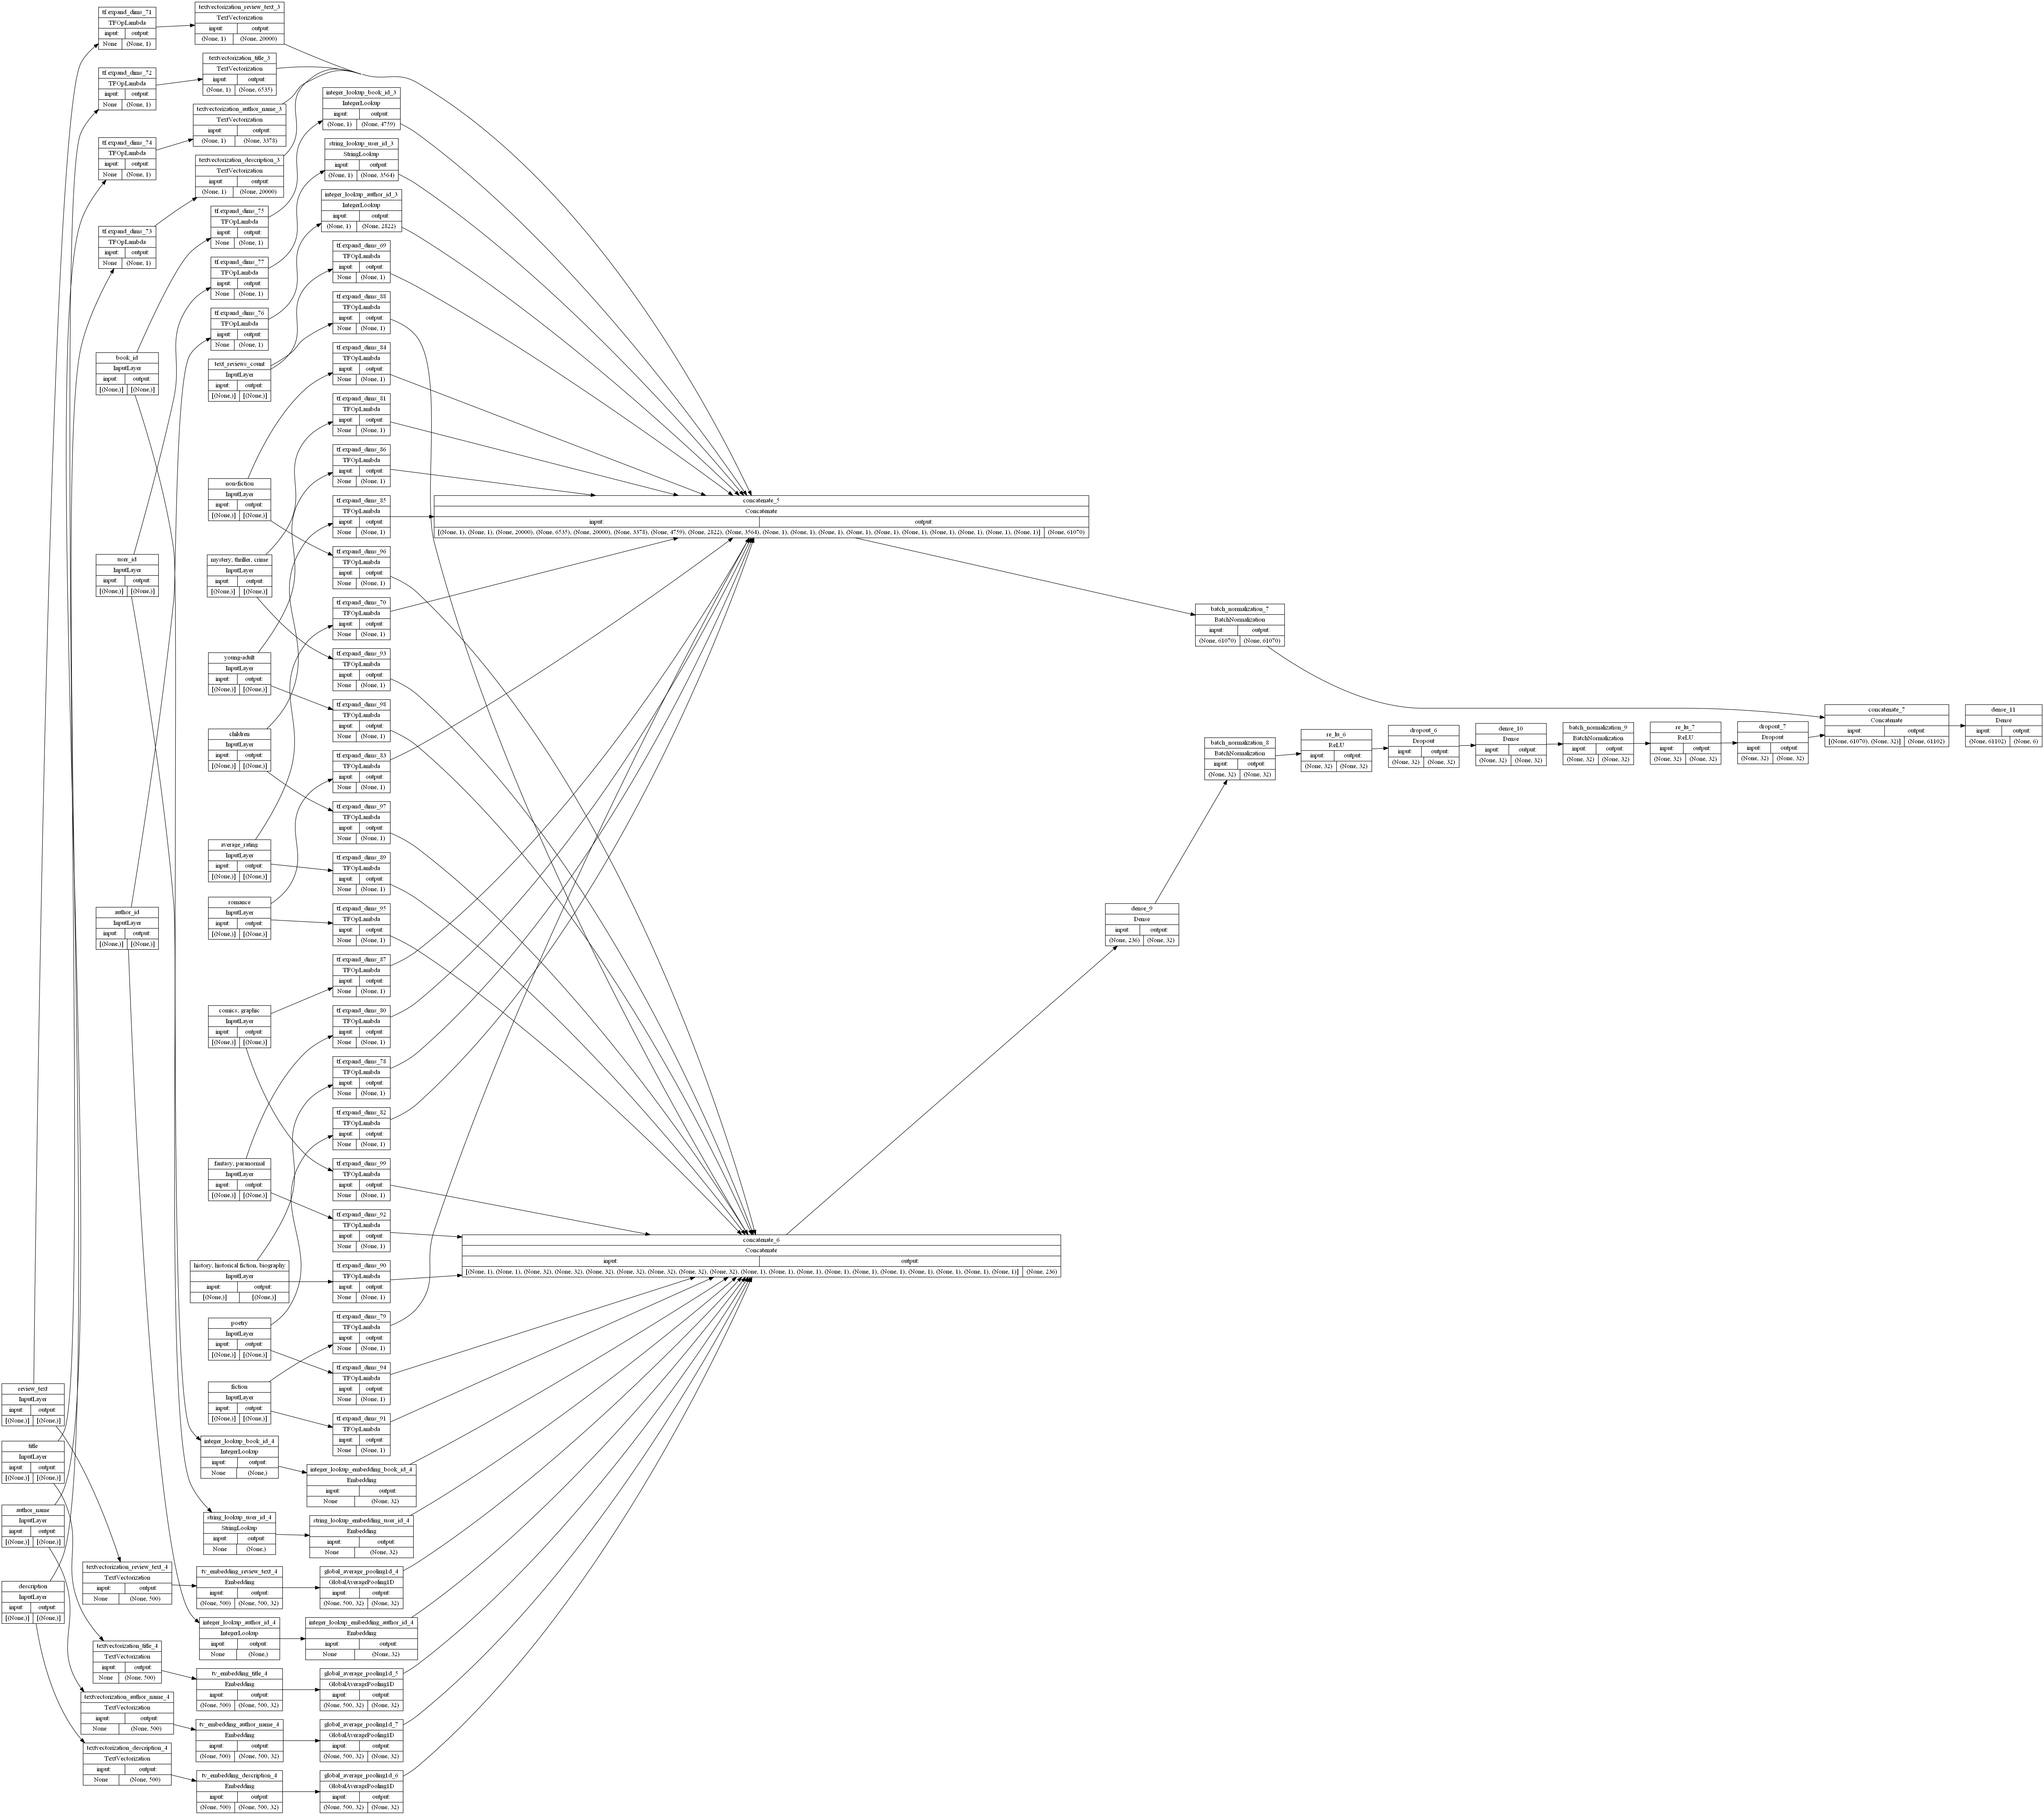

In [ ]:
def create_wide_and_deep_model():

    inputs = create_model_inputs()
    wide = encode_inputs(inputs)
    wide = layers.BatchNormalization()(wide)

    deep = encode_inputs(inputs, use_embedding=True)
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([wide, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


wide_and_deep_model = create_wide_and_deep_model()
plot_fn = os.path.join("./logs/model_plots/", "wide_and_deep_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(wide_and_deep_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [ ]:
run_experiment(wide_and_deep_model)

setting up yagmail...
Start training the model...
Start Training with Model: 
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 review_text (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 title (InputLayer)             [(None,)]            0           []                               
                                                                                                  
 description (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 author_name (InputLayer)       [(None,)]            0           []                               
              

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\simon\\AppData\\Local\\Temp\\tmp0i7s5f03.png'

---
## Experiment 3: Deep & Cross model
In the third experiment, we create a Deep & Cross model. The deep part of this model is the same as the deep part created in the previous experiment. The key idea of the cross part is to apply explicit feature crossing in an efficient way, where the degree of cross features grows with layer depth.

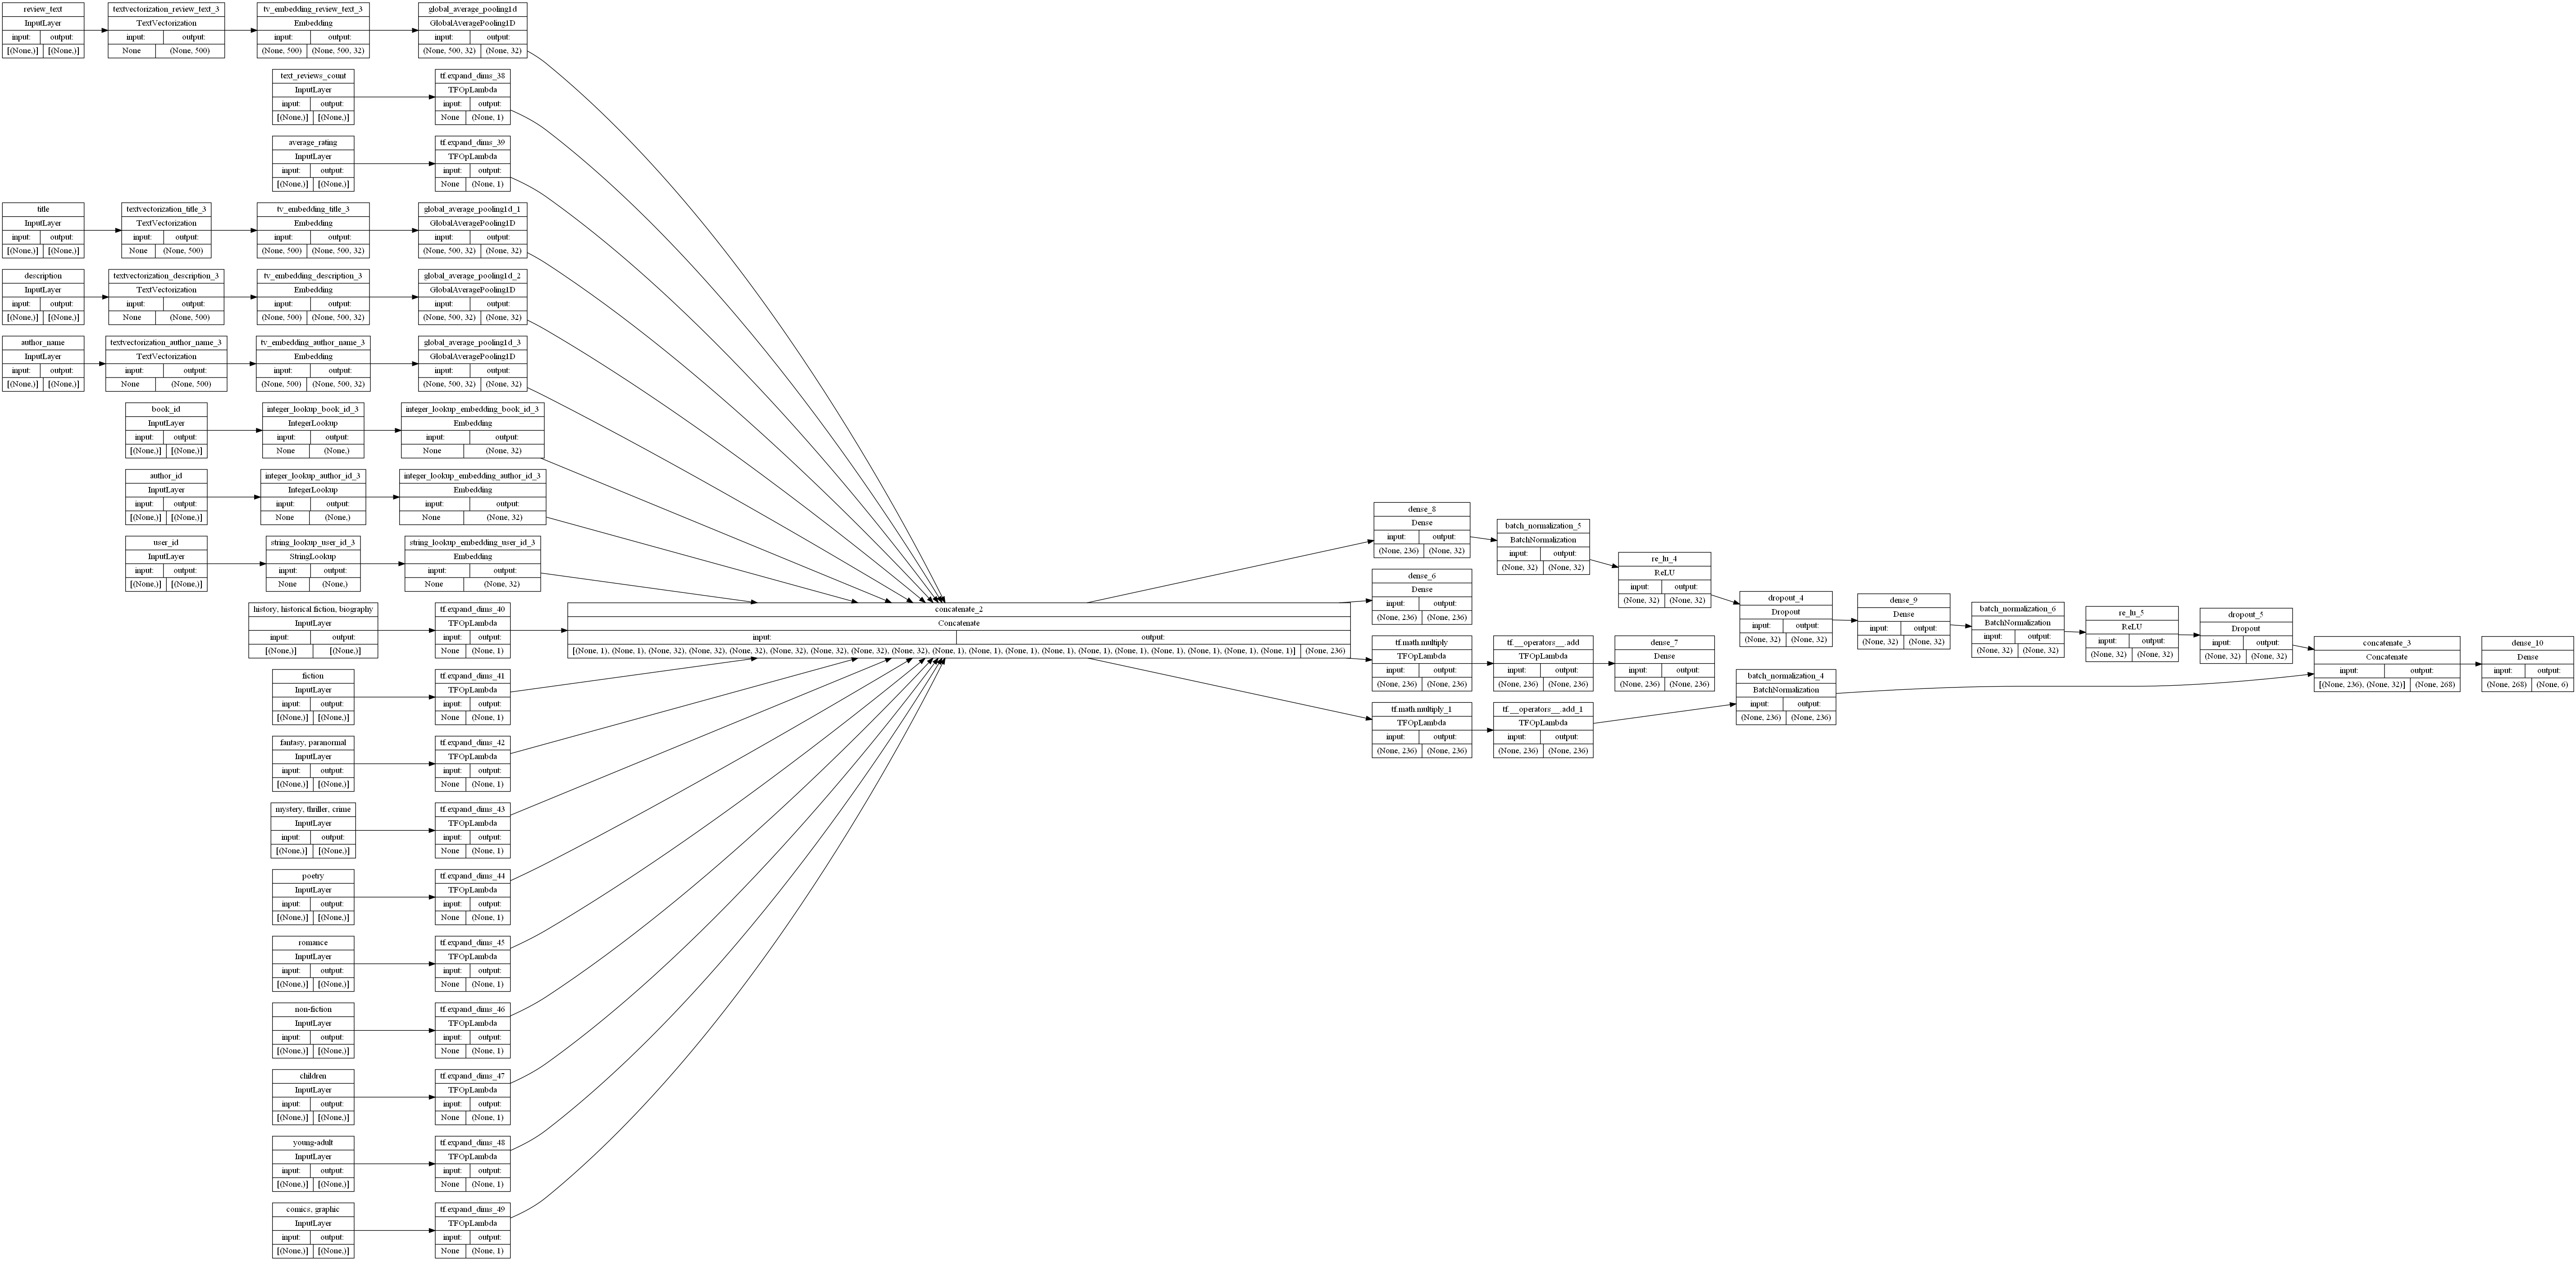

In [54]:
def create_deep_and_cross_model():

    inputs = create_model_inputs()
    x0 = encode_inputs(inputs, use_embedding=True)

    cross = x0
    for _ in hidden_units:
        units = cross.shape[-1]
        x = layers.Dense(units)(cross)
        cross = x0 * x + cross
    cross = layers.BatchNormalization()(cross)

    deep = x0
    for units in hidden_units:
        deep = layers.Dense(units)(deep)
        deep = layers.BatchNormalization()(deep)
        deep = layers.ReLU()(deep)
        deep = layers.Dropout(dropout_rate)(deep)

    merged = layers.concatenate([cross, deep])
    outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


deep_and_cross_model = create_deep_and_cross_model()
plot_fn = os.path.join("./logs/model_plots/", "deep_and_cross_model_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + ".png")

keras.utils.plot_model(deep_and_cross_model, to_file=plot_fn, show_shapes=True, rankdir="LR")


In [55]:
run_experiment(deep_and_cross_model)

setting up yagmail...
Start training the model...
Start Training with Model: 
Model: "model_2"__________________________________________________________________________________________________ Layer (type)                   Output Shape         Param #     Connected to                     ================================================================================================== review_text (InputLayer)       [(None,)]            0           []                                                                                                                                  title (InputLayer)             [(None,)]            0           []                                                                                                                                  description (InputLayer)       [(None,)]            0           []                                                                                                                                  author_name (InputLayer

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\simon\\AppData\\Local\\Temp\\tmpdkw5ylgm.png'